# Problem approach
The end goal is to utilise a clear box machine learning technique (decision tree) that will display which factors are most correlated to the happiness index score. Thus it is necessary to convert the training data (when it is assembled) so that its output variable is in the form of a classification problem (through binning).

In [1]:
%matplotlib inline

In [2]:
import pandas as pa
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import pydot

from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

### Loading Data

In [3]:
outputLabels =  pa.read_csv('happiness.csv',encoding ='ISO-8859-1')
wdiData = pa.read_csv("WDI_csv/WDI_Data.csv",encoding ='ISO-8859-1')


### Get latest year's data only

In [4]:
validYearData = wdiData[['Country Name','Indicator Name','2015']]
validYearData[1:5]

,Country Name,Indicator Name,2015
1,Arab World,"2005 PPP conversion factor, private consumptio...",NaN
2,Arab World,Access to electricity (% of population),NaN
3,Arab World,"Access to electricity, rural (% of rural popul...",NaN
4,Arab World,"Access to electricity, urban (% of urban popul...",NaN


### Pivot table so that features are column headings

In [5]:
featureData = validYearData.pivot('Country Name', 'Indicator Name')['2015']
featureData[1:3]

Indicator Name,"2005 PPP conversion factor, GDP (LCU per international $)","2005 PPP conversion factor, private consumption (LCU per international $)",ARI treatment (% of children under 5 taken to a health provider),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Access to non-solid fuel (% of population),"Access to non-solid fuel, rural (% of rural population)","Access to non-solid fuel, urban (% of urban population)",Account at a financial institution (% age 15+) [ts],...,Wholesale price index (2010 = 100),Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),"Youth literacy rate, population 15-24 years, both sexes (%)"
Country Name,,,,,,,,,,,,,,,,,,,,,
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,108.510959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Get feature labels of the features with the most data values (not null values)

In [6]:
#show feature labels in decending order of how many values they have in the data set
featureData.count().sort_values(ascending =False)[1:20]

Indicator Name
Population, total                                      262
Land area (sq. km)                                     262
Population growth (annual %)                           262
Bird species, threatened                               261
International migrant stock, total                     261
Fish species, threatened                               261
Mammal species, threatened                             261
Population density (people per sq. km of land area)    261
Plant species (higher), threatened                     261
Urban population                                       260
Rural population                                       260
Rural population (% of total population)               260
International migrant stock (% of population)          260
Urban population (% of total)                          260
Urban population growth (annual %)                     260
Forest area (sq. km)                                   257
Forest area (% of land area)             

In [7]:
def topMostDataFeatures(takeNumber):    
    topMostData = featureData.count().sort_values(ascending =False)[1:takeNumber]
    output = []
    for featureIndex in topMostData.index:
        output.append(featureIndex)
    return output

topDataFeaturesArray = topMostDataFeatures(60)

In [8]:
#extract just the top features
featureTrainingData = featureData[:][topDataFeaturesArray]


### Join feature data to happiness index data 

In [9]:
outputLabelsToJoin = outputLabels.set_index('Country')[['Happiness.2016']]
outputLabelsToJoin.index = outputLabelsToJoin.index.str.strip()
outputLabelsToJoin[1:10]

,Happiness.2016
Country,
Switzerland,7.509
Iceland,7.501
Norway,7.498
Finland,7.413
Canada,7.404
Netherlands,7.339
New Zealand,7.334
Australia,7.313
Sweden,7.291


In [10]:
# join data frames
completeTrainingData = outputLabelsToJoin.join(featureTrainingData)

# show section of full dataset with happiness index attached
completeTrainingData[1:5]

,Happiness.2016,"Population, total",Land area (sq. km),Population growth (annual %),"Bird species, threatened","International migrant stock, total","Fish species, threatened","Mammal species, threatened",Population density (people per sq. km of land area),"Plant species (higher), threatened",...,Time to prepare and pay taxes (hours),Ease of doing business index (1=most business-friendly regulations),Distance to frontier score (0=lowest performance to 100=frontier),"Improved sanitation facilities, rural (% of rural population with access)",Private credit bureau coverage (% of adults),Business extent of disclosure index (0=less disclosure to 10=more disclosure),Cost of business start-up procedures (% of GNI per capita),Time required to enforce a contract (days),Tax payments (number),Total tax rate (% of commercial profits)
Country,,,,,,,,,,,,,,,,,,,,,
Switzerland,7.509,8286976.0,39516.0,1.193620,6.0,2438702.0,9.0,2.0,209.711914,10.0,...,63.0,26.0,76.04,99.8,26.1,0.0,2.0,390.0,19.0,28.8
Iceland,7.501,330823.0,100250.0,1.044359,4.0,37522.0,16.0,6.0,3.299980,0.0,...,140.0,19.0,78.93,100.0,100.0,7.0,2.2,417.0,21.0,29.6
Norway,7.498,5195921.0,365245.0,1.135948,7.0,741813.0,23.0,7.0,14.225851,14.0,...,83.0,9.0,81.61,98.3,100.0,7.0,0.9,280.0,4.0,39.5
Finland,7.413,5482013.0,303890.0,0.374669,9.0,315881.0,6.0,1.0,18.039465,8.0,...,93.0,10.0,81.05,88.0,20.5,6.0,1.0,375.0,8.0,37.9


### Clean data by removing any rows with null fields 

In [11]:
def removeColumnsWithNulls(topDataFeaturesArray,dataset):
    output = copy.deepcopy(dataset)
    for feature in topDataFeaturesArray:
        output = output[pa.notnull(output[feature])]
    return output

cleanedCompleteTrainingData = removeColumnsWithNulls(topDataFeaturesArray,completeTrainingData)

### Bin happiness index (convert to binary classification problem)

In [12]:
midPoint = ((max(cleanedCompleteTrainingData['Happiness.2016']) - min(cleanedCompleteTrainingData['Happiness.2016']))/2)+ min(cleanedCompleteTrainingData['Happiness.2016'])
desiredOutput = cleanedCompleteTrainingData['Happiness.2016'] > midPoint
inputData = cleanedCompleteTrainingData[topDataFeaturesArray]

### Train decision tree

In [13]:
clf = DecisionTreeClassifier()
clf = clf.fit(inputData, desiredOutput)
cross_val_score(clf, inputData, desiredOutput)

array([ 0.6744186 ,  0.63414634,  0.58536585])

In [14]:
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_pdf("iris.pdf") 

True

### Display decision tree 

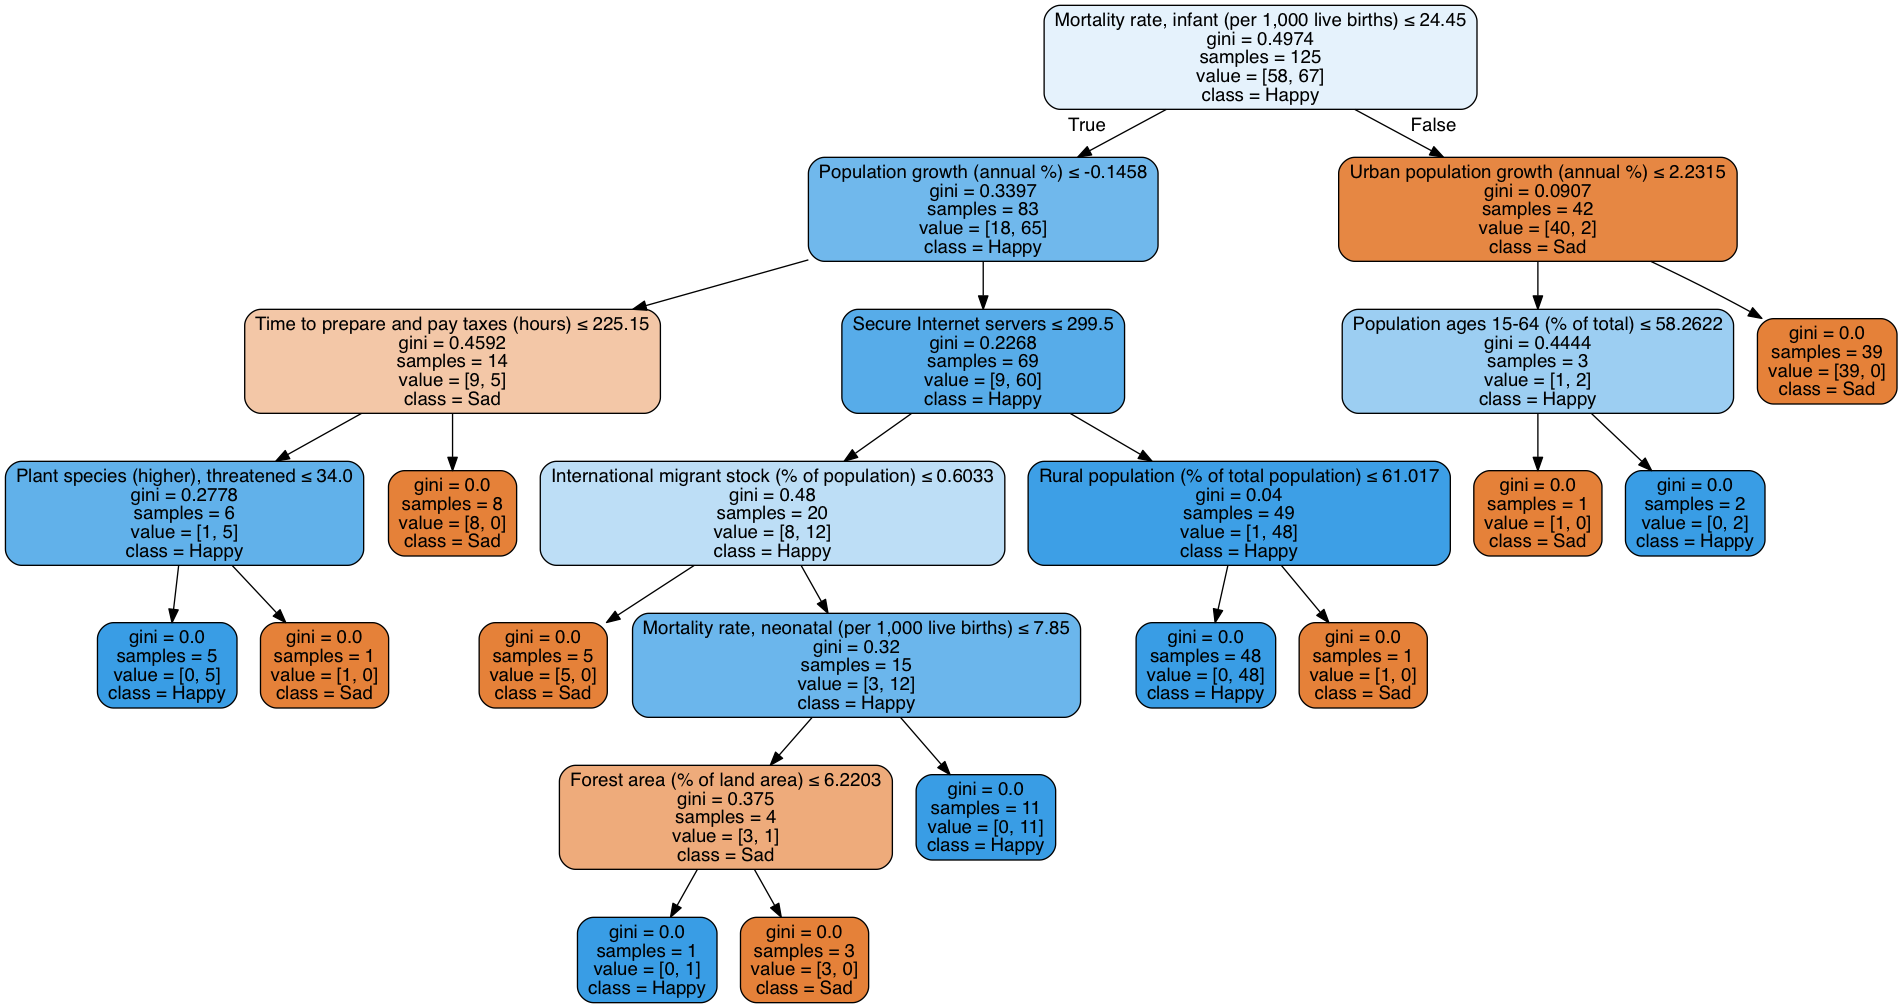

In [15]:
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                     feature_names=topDataFeaturesArray,  
                     class_names=['Sad','Happy'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png()) 

## Judgement on results
The nodes near the top of the decision tree show to be key deciding factors in classifying whether or not a country is "happy". Below are some plots of these factors against the happiness index which prove their correlation.

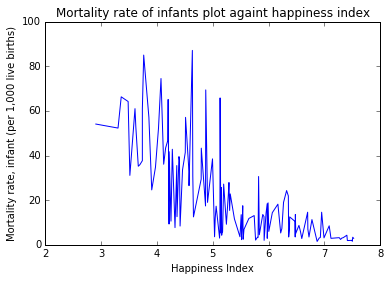

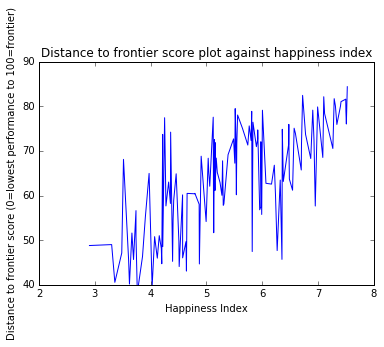

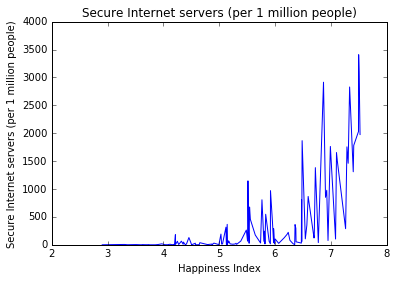

In [16]:
plt.plot(cleanedCompleteTrainingData['Happiness.2016'],cleanedCompleteTrainingData['Mortality rate, infant (per 1,000 live births)'])
plt.ylim([0,100])
plt.xlabel('Happiness Index')
plt.ylabel('Mortality rate, infant (per 1,000 live births)')
plt.title('Mortality rate of infants plot againt happiness index')
plt.show()

plt.plot(cleanedCompleteTrainingData['Happiness.2016'],cleanedCompleteTrainingData['Distance to frontier score (0=lowest performance to 100=frontier)'])
plt.ylim([40,90])
plt.xlabel('Happiness Index')
plt.title('Distance to frontier score plot against happiness index')
plt.ylabel('Distance to frontier score (0=lowest performance to 100=frontier)')
plt.show()

plt.plot(cleanedCompleteTrainingData['Happiness.2016'],cleanedCompleteTrainingData[topDataFeaturesArray[19]])
plt.ylim([0,4000])
plt.xlabel('Happiness Index')
plt.ylabel(topDataFeaturesArray[19])
plt.title(topDataFeaturesArray[19])
plt.show()

# Final thoughts
A link can be drawn between all of these correlative factors with technological advancement and distribution within a country.